Credits to Elissaios Sarmas for the code, which was adapted for use on this dataset (credits to Xiaomin Chang). Code can be found here: https://github.com/ElissaiosSarmas/Transfer-learning-strategies-for-solar-power-forecasting-under-data-scarcity

In [22]:
# Clear any logs from previous runs
!rm -r ./LSTM_w_TL_1/logs

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import tensorflow as tf
import datetime, os

from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras_layer_normalization import LayerNormalization
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow import keras
from tensorflow.keras import Input,Model
from tensorflow.keras.models import load_model
import time
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from hyperopt import fmin, tpe, hp, partial, Trials, STATUS_OK, STATUS_FAIL, space_eval
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import layers

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score 
from sklearn import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt
from sklearn.metrics import mean_squared_error, zero_one_loss,mean_absolute_error,r2_score
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [24]:
path = "C:/work/Honours code/Datasets/all_data.csv"

p1 = pd.read_csv(path, header=0)

In [25]:
p1_copy = p1.copy()
p1_copy['timestamp'] = pd.to_datetime(p1['period_end'], format='ISO8601')

p1_copy.drop(['period_end'], axis=1, inplace=True)

# dropping columns that are not needed
p1_copy.drop(['Unnamed: 0', 'period_x', 'period_y', '_id_x', '_id_y'], axis=1, inplace=True)

# make the timestamp the first column
timestamp = p1_copy.pop('timestamp')
p1_copy.insert(0, 'timestamp', timestamp)

# extract the hour and month from the timestamp
p1_copy['hour'] = pd.to_datetime(p1_copy['timestamp']).dt.hour
p1_copy['month'] = pd.to_datetime(p1_copy['timestamp']).dt.month

In [26]:
p1_copy.head()

,timestamp,ghi,ghi90,ghi10,ebh,dni,dni10,dni90,dhi,air_temp,zenith,azimuth,cloud_opacity,pv_estimate,hour,month
0,2018-07-30 11:30:00+00:00,0,0,0,0,0,0,0,0,13,140,102,0,0.0,11,7
1,2018-07-30 12:00:00+00:00,0,0,0,0,0,0,0,0,13,146,108,0,0.0,12,7
2,2018-07-30 12:30:00+00:00,0,0,0,0,0,0,0,0,13,152,116,0,0.0,12,7
3,2018-07-30 13:00:00+00:00,0,0,0,0,0,0,0,0,12,157,127,1,0.0,13,7
4,2018-07-30 13:30:00+00:00,0,0,0,0,0,0,0,0,12,162,143,1,0.0,13,7


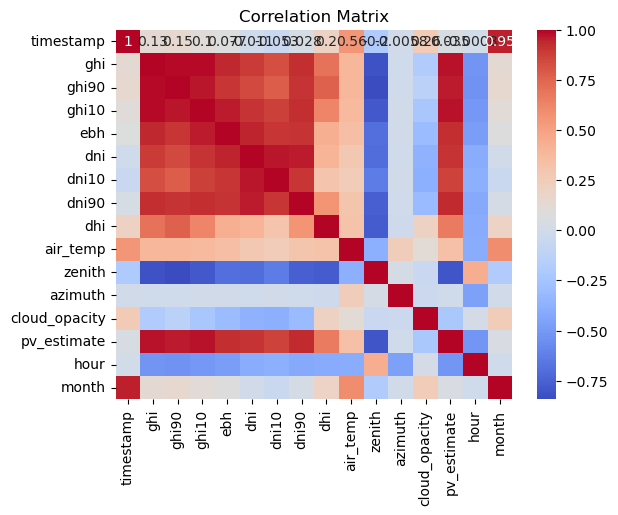

In [27]:
corr_matrix = p1_copy.corr()
# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

The first few variables seem highly correlated. Let's try removing the variables with angles and see if it improves visually.

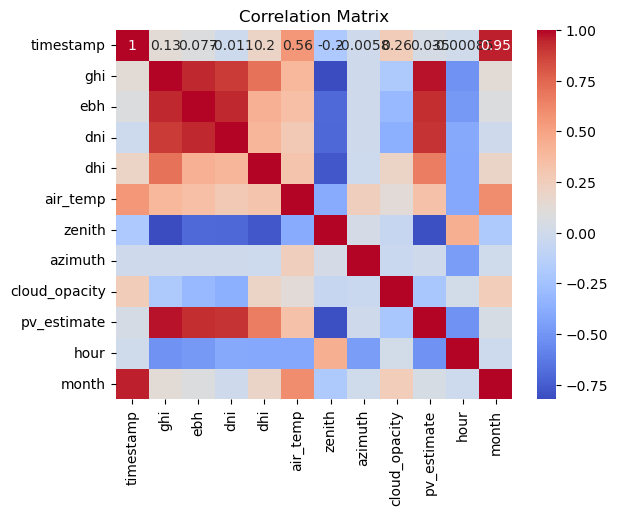

In [28]:
cols_to_keep = ['timestamp', 'ghi', 'ebh', 'dni', 'dhi', 'air_temp', 'zenith', 'azimuth', 'cloud_opacity', 'pv_estimate', 'hour', 'month']
corr_plot2 = p1_copy[cols_to_keep]
corr_mat2 = corr_plot2.corr()
# Plot the correlation matrix
sns.heatmap(corr_mat2, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

It does seem to improve visually, so we'll drop those variables.

In [29]:
p1_copy_2 = p1_copy.drop(['ghi90', 'ghi10', 'dni10', 'dni90'], axis=1)

In [30]:

# Perform One-Hot-Encoding for Months and Sin-Cos Similarities for Hours
data = p1_copy_2
data['timestamp'] = pd.to_numeric(data['timestamp'])
#data = pd.get_dummies(data, columns=['month'])
data.loc[:,'sin_hour'] = np.sin(2*np.pi*data['timestamp']/24)
data.loc[:,'cos_hour'] = np.cos(2*np.pi*data['timestamp']/24)

print("Total Entries =", len(data))

Total Entries = 3705


In [31]:
# Shaping data for LSTM input
def split_sequences(sequences, n_steps, n_outputs, only_production, validation_split):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern 
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix + n_outputs > len(sequences):
            break
        # gather input and output parts of the pattern
        if only_production==True:
            seq_x, seq_y = sequences[i:end_ix, -1], sequences[end_ix:(end_ix+n_outputs), -1]
        else:
            seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:(end_ix+n_outputs), -1]
            
        X.append(seq_x)
        y.append(seq_y)
    
    # Convert to numpy arrays
    X, y = np.array(X), np.array(y)
    
    # Split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, random_state=42)
    
    return x_train, x_val, y_train, y_val

In [32]:
def unique_shapes(x, y, lag_, n_features_, num_of_outputs_, only_production, validation_split):
    unique_shapes = []
    for k in range(len(x)):
        if only_production==True:
            if (x[k].shape == (lag,)) & (y[k].shape == (num_of_outputs_,)):
                unique_shapes.append(k)
        else:
            if (x[k].shape == (lag_, n_features_)) & (y[k].shape == (num_of_outputs_,)):
                unique_shapes.append(k)       
    x = x[unique_shapes]
    y = y[unique_shapes]
    x = np.stack(x)
    y = np.stack(y)
    
    # Split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=validation_split, random_state=42)
    
    return x_train, x_val, y_train, y_val

In [33]:
cols = data.columns.tolist()
cols

['timestamp',
 'ghi',
 'ebh',
 'dni',
 'dhi',
 'air_temp',
 'zenith',
 'azimuth',
 'cloud_opacity',
 'pv_estimate',
 'hour',
 'month',
 'sin_hour',
 'cos_hour']

In [34]:
# Select the columns that you want to use as features
cols = ['timestamp',
 'ghi',
 'ebh',
 'dhi',
 'air_temp',
 'azimuth',
 'cloud_opacity',
 'sin_hour',
 'cos_hour',
 'pv_estimate']
# I need to have 10 features to match the padding. I'll remove hour, month, dni and zenith.

# Set to True if using only the production, else to False
only_production = False
# Splitting factor for training set and test set
split = 0.4

# Select the lag variable, the number of features (must be same with cols selected) and the horizon
lag = 5
n_features = len(cols)
num_of_outputs = 1

Padding the data to match the domain dataset

In [35]:
timesteps = 5
features = 10
from tensorflow.keras.preprocessing.sequence import pad_sequences
data_array = data['timestamp'].values
# flatten the data
data_array = data_array.reshape(-1)
total_features = ((len(data_array) // (timesteps * features)) + 1) * (timesteps * features)
# calculate the padding
padding = total_features - len(data_array)
# pad the data
data_padded = np.pad(data_array, (0, padding), 'constant')

# Reshape the data
data_padded = data_padded.reshape(-1, timesteps, features)

print(data_padded.shape)

(75, 5, 10)


In [37]:
# Scale data seperately
from sklearn.preprocessing import MinMaxScaler

if only_production == True:
    data_ = data_['SystemProduction']
    train = data_.iloc[:int(len(data_)*split_),]
    test = data_.iloc[int(len(data_)*split_):,]
    scaler = MinMaxScaler(feature_range=(0, 1))
    train = scaler.fit_transform(train.values.reshape(-1, 1))
    test = scaler.fit_transform(test.values.reshape(-1, 1))
else:
    # convert numpy array to pandas dataframe
    # data = pd.DataFrame(data_padded.reshape(-1, features))
    # flatten the data
    data = data_padded.reshape(-1, len(cols))
    print(data.shape)
    data = pd.DataFrame(data, columns=cols)
    data = data[cols]
    train = data.iloc[:int(len(data)*split),:]
    test = data.iloc[int(len(data)*split):,]
    scaler = MinMaxScaler(feature_range=(0,1))
    train = scaler.fit_transform(train)
    test = scaler.fit_transform(test)

(375, 10)


In [38]:
# Create the input for LSTM: x(batch_size, lag, features), y(batch_size,)

x_train, x_val, y_train, y_val = split_sequences(train, n_steps=lag, n_outputs=num_of_outputs, only_production=only_production, validation_split=split)
x_test, x_val, y_test, y_val = split_sequences(test, n_steps=lag, n_outputs=num_of_outputs, only_production=only_production, validation_split=split)

x_train, x_val, y_train, y_val = unique_shapes(x_train, y_train, lag, n_features, num_of_outputs, only_production=only_production, validation_split=split)
x_test, x_val, y_test, y_val = unique_shapes(x_test, y_test, lag, n_features, num_of_outputs, only_production=only_production, validation_split=split)


# Reshape for only_production case
if only_production:
    x_train = x_train.reshape((x_train.shape[0], lag, 1))
    x_test = x_test.reshape((x_test.shape[0], lag, 1))
else:
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])
# Print the shapes
print("Size of Train / Test =", x_train.shape, y_train.shape, x_test.shape, y_test.shape)


Size of Train / Test = (52, 5, 10) (52, 1) (79, 5, 10) (79, 1)


In [40]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred))))



base_model_path = "C:/work/Honours code/Transfer learning/LSTM/LSTM_base.h5"

def createModel():

    # BI-LSTM Model Architecture

    # Load Base model
    if os.path.exists(base_model_path):
        model = load_model(base_model_path)
    else:
        print("Base model not found")
        
    model.layers[0].trainable = False
    model.layers[1].trainable = False

    # Remove the last 2 layers
    # model.pop()
    # model.pop()
    output = model.layers[-3].output  # Retaining up to the third last layer
    new_model = Model(inputs=model.inputs, outputs=output)
    #new_model = Model(inputs=model.inputs)
    
    inputs = Input(shape=(x_train.shape[1:]))
    x = new_model(inputs, training=False)
    # x = model(inputs, training=False)
    print("Input shape:", x_train.shape)
    x = Bidirectional(LSTM(16, activation="relu", return_sequences=False))(x)
    x = Dropout(0.27)(x)

    # x = Dense(500, activation="relu")(x)
    outputs  = Dense(1)(x)

    new_model = Model(inputs, outputs)

    # Compile model
    optimizer = Adam(learning_rate=0.00083)
    new_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    new_model.summary()

    return new_model

In [41]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler
from keras.layers import TFSMLayer
from tensorflow.keras import backend as K
import h5py
import os
import time
timestamp = int(time.time())
true_values = []
predicted_values = []
model_path = "LSTM_model_1.h5"
K.clear_session()
def fit_predict_stats(model):
    # Early stopping property
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    tb = TensorBoard(log_dir='logs')
    experiment_name = 'run_2'
    log_dir = f'./logs/{experiment_name}'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1, shuffle=True, callbacks=[tensorboard_callback, es]).history
    
    # Model fine-tuning
    model.trainable = True
    model.layers[0].trainable = True
    model.layers[1].trainable = True
    optimizer = Adam(learning_rate=0.0001) # Decreasing the learning rate to prevent overfitting
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    history = model.fit(x_train, y_train, epochs=20, validation_split=0.2, batch_size=128, verbose=1, shuffle=True, callbacks=[tensorboard_callback, es]).history
    
    if os.path.exists(model_path):
        
    # Load the model
        tf.debugging.set_log_device_placement(True)
        model = load_model(model_path)
    else:
        # Model file does not exist, so save the model
        
        # Fit the model
        
        model.save(model_path, overwrite=True)

    
    # summarize history for MAE and MSE
    # plt.plot(history['loss'])
    # plt.plot(history['val_loss'])
    # plt.title('model loss')
    # plt.ylabel('Model MSE')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'val'], loc='upper left')

    # plt.figure()
    # plt.plot(history['mae'])
    # plt.plot(history['val_mae'])
    # plt.title('Model MAE')
    # plt.ylabel('MAE')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'val'], loc='upper left')

    # Metrics on scaled data
    
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    y_pred = model.predict(x_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    mae = mean_absolute_error(y_train, y_pred)
    # print('Train Scaled RMSE: {}'.format(rmse))
    # print('Train Scaled MAE: {}'.format(mae))
    # print('Train Scaled R2 Score: ', r2_score(y_train, y_pred)*100)

    y_pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    # print('Test Scaled RMSE: {}'.format(rmse))
    # print('Test Scaled MAE: {}'.format(mae))
    # print('Test Scaled R2 Score: ',r2_score(y_test, y_pred)*100)


    
    # Metrics on original data
    true = []
    hat = []
    range_ = [0]
    # range_ = list(range(6))

    for i,j in zip([[x_train,y_train],[x_test,y_test]],['Train','Test']):
        # make a prediction
        yhat = model.predict(i[0])
        if yhat.shape == (yhat.shape[0],):
            yhat = yhat.reshape((yhat.shape[0],1))  
      
        y_hat = []
        for k in range(len(yhat)):
            if k == 0:
                for l in range_:
                    y_hat.append(yhat[k,l])
            else:
                y_hat.append(yhat[k,-1])
        
        y_hat = np.stack(y_hat)
        y_hat = y_hat.reshape((y_hat.shape[0],1))

        ### trying to resolve the issue of different shapes
        total_elements = np.product(i[0].shape)
        lag = i[0].shape[1]
        n_features = i[0].shape[2]
        print("Total elements in data:", total_elements)
        ###
        
        i[0] = i[0].reshape((i[0].shape[0],lag,n_features))
        
        x_hat = []
        for k in range(len(i[0])):
            if k == 0:
                x_hat.append(i[0][k])
            elif k!= 0:
                x_hat.append(i[0][k][-1,:])
        
        x_hat = np.vstack(x_hat)
        
        initial_x_hat_shape = x_hat.shape[0]
        initial_y_hat_shape = y_hat.shape[0]
        
        print(x_hat.shape)
        print(y_hat.shape)
        
        if x_hat.shape[0]-y_hat.shape[0] != 0.0:
            if x_hat.shape[0] > y_hat.shape[0]:
                for k in range(x_hat.shape[0]-y_hat.shape[0]):
                    y_hat = np.insert(y_hat, 0, y_hat[0,0], axis=0)
                    added_values = True
            elif x_hat.shape[0] < y_hat.shape[0]:
                y_hat = y_hat[-int(x_hat.shape[0]-y_hat.shape[0]):,:]
                added_values = False
        
        print(x_hat[:,:-1].shape)
        print(y_hat.shape)
        
        # invert scaling for forecast
        if only_production==True:
            inv_yhat = np.concatenate((x_hat[:,:-1],y_hat), axis=1)
            inv_yhat = scaler.inverse_transform(inv_yhat)
        else:    
            inv_yhat = np.concatenate((x_hat[:,:-1],y_hat), axis=1)
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            
        # invert scaling for actual
        y_true = []
        for k in range(len(i[1])):
            if k ==0:
                for l in range_:
                    y_true.append(i[1][k,l])
            else:
                y_true.append(i[1][k,-1])

        y_true = np.stack(y_true)
        y_true = y_true.reshape((y_true.shape[0],1))
        print(y_true.shape)

        initial_y_true_shape = y_true.shape[0]
        
        if x_hat.shape[0]-y_true.shape[0] != 0.0:
            if x_hat.shape[0] > y_true.shape[0]:
                for k in range(x_hat.shape[0]-y_true.shape[0]):
                    y_true = np.insert(y_true, 0, y_true[0,0], axis=0)
                    added_values = True
            elif x_hat.shape[0] < y_true.shape[0]:
                y_true = y_true[-int(x_hat.shape[0]-y_true.shape[0]):,:]
                added_values = False
                
        if only_production==True:
            inv_y = np.concatenate((x_hat[:,:-1],y_true), axis=1)
            inv_y = scaler.inverse_transform(inv_y)
        else:
            inv_y = np.concatenate((x_hat[:,:-1],y_true), axis=1)
            inv_y = scaler.inverse_transform(inv_y)
            inv_y = inv_y[:,-1]
        
        true.append(inv_y)
        hat.append(inv_yhat)

        # true_values.append(true)
        # predicted_values.append(hat)
        
        # calculate RMSE
        rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate MAE
        mae = mean_absolute_error(inv_y, inv_yhat)
        print('Test MAE: %.3f' % mae)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print('Test R2 Score: ',r2)
        # Calculate MAPE
        mape = mean_absolute_percentage_error(inv_y, inv_yhat)
        print('MAPE', mape)
        # Calculate MBE
        mbe = np.mean(inv_yhat - inv_y)
        print('Test MBE', mbe)
        # Calculate nRMSE
        nRMSE = rmse / np.mean(inv_y)
        print('nRMSE', nRMSE)

        



    mae_list.append(mae)
    rmse_list.append(rmse)
    r_square_list.append(r2)
    mape_list.append(mape)
    mbe_list.append(mbe)
    nRMSE_list.append(nRMSE)



In [42]:
mae_list = []
rmse_list = []
r_square_list = []
mape_list = []
mbe_list = []
nRMSE_list = []
num_iterations = 20
#num_iterations = 2
for i in range(num_iterations):
    print("Shape of x_train:", x_train.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of x_test:", x_test.shape)
    print("Shape of y_test:", y_test.shape)
    model = createModel()
    keras.config.disable_traceback_filtering()
    fit_predict_stats(model)

# sns.set_style("darkgrid")
# for true, hat in zip(true_values, predicted_values):
#     plt.figure()
#     plt.plot(true[1], color="green")
#     plt.plot(hat[1], color="red")
#     plt.savefig('plots/lstm_base_plot.png')
    #plt.show()

print("MAE:", mae_list)
print("RMSE:", rmse_list)
print("R^2:", r_square_list)
print("MAPE:", mape_list)
print("MBE:", mbe_list)
print("nRMSE:", nRMSE_list)

print("Mean MAE:", np.mean(mae_list))
print("Mean RMSE:", np.mean(rmse_list))
print("Mean R^2:", np.mean(r_square_list))
print("Mean MAPE:", np.mean(mape_list))
print("Mean MBE:", np.mean(mbe_list))
print("Mean nRMSE:", np.mean(nRMSE_list))


Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


Input shape: (52, 5, 10)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_5 (Functional)       │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32)             │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.3939 - mae: 0.5707 - val_loss: 0.1997 - val_mae: 0.3796
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.3381 - mae: 0.5207 - val_loss: 0.1609 - val_mae: 0.3360
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2738 - mae: 0.4653 - val_loss: 0.1245 - val_mae: 0.2900
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2275 - mae: 0.4123 - val_loss: 0.0910 - val_mae: 0.2410
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1675 - mae: 0.3434 - val_loss: 0.0608 - val_mae: 0.1914
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1329 - mae: 0.3005 - val_loss: 0.0356 - val_mae: 0.1427
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0827 - mae: 0.2185 - val_loss: 0.0176 - val_mae: 0.1004
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0501 - mae: 0.1594 - val_loss: 0.0078 - val_mae: 0.0734
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0368 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_13 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.3709 - mae: 0.5481 - val_loss: 0.1883 - val_mae: 0.3693
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2999 - mae: 0.4873 - val_loss: 0.1624 - val_mae: 0.3412
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.2651 - mae: 0.4574 - val_loss: 0.1393 - val_mae: 0.3140
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2352 - mae: 0.4278 - val_loss: 0.1176 - val_mae: 0.2865
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1983 - mae: 0.3874 - val_loss: 0.0968 - val_mae: 0.2576
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2123 - mae: 0.3961 - val_loss: 0.0773 - val_mae: 0.2274
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1582 - mae: 0.3357 - val_loss: 0.0592 - val_mae: 0.1959
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1095 - mae: 0.2729 - val_loss: 0.0428 - val_mae: 0.1633
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1100 - mae: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_21 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32)             │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.7167 - mae: 0.7821 - val_loss: 0.4121 - val_mae: 0.5625
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.6847 - mae: 0.7684 - val_loss: 0.3558 - val_mae: 0.5191
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.5806 - mae: 0.6968 - val_loss: 0.3088 - val_mae: 0.4797
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.5093 - mae: 0.6504 - val_loss: 0.2698 - val_mae: 0.4447
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.4319 - mae: 0.5903 - val_loss: 0.2338 - val_mae: 0.4107
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3943 - mae: 0.5727 - val_loss: 0.1998 - val_mae: 0.3764
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.3190 - mae: 0.5037 - val_loss: 0.1674 - val_mae: 0.3408
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2884 - mae: 0.4818 - val_loss: 0.1365 - val_mae: 0.3050
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2392 - mae: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


Input shape: (52, 5, 10)


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_29 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 32)             │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.1372 - mae: 0.3297 - val_loss: 0.0489 - val_mae: 0.1835
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.0974 - mae: 0.2460 - val_loss: 0.0214 - val_mae: 0.1135
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0493 - mae: 0.1597 - val_loss: 0.0061 - val_mae: 0.0475
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0463 - mae: 0.1564 - val_loss: 0.0022 - val_mae: 0.0396
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0170 - mae: 0.1015 - val_loss: 0.0061 - val_mae: 0.0685
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0222 - mae: 0.1225 - val_loss: 0.0133 - val_mae: 0.1046
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0371 - mae: 0.1601 - val_loss: 0.0165 - val_mae: 0.1171
Epoch 7: early stopping
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.0358 - mae: 0.1583 - val_loss: 0.0152 - val_mae: 0.1119
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step 

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


Input shape: (52, 5, 10)


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_37 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 32)             │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.4739 - mae: 0.6382 - val_loss: 0.2431 - val_mae: 0.4321
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.4015 - mae: 0.5832 - val_loss: 0.2023 - val_mae: 0.3935
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3455 - mae: 0.5383 - val_loss: 0.1688 - val_mae: 0.3585
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3048 - mae: 0.5000 - val_loss: 0.1397 - val_mae: 0.3249
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2521 - mae: 0.4444 - val_loss: 0.1132 - val_mae: 0.2908
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2228 - mae: 0.4239 - val_loss: 0.0882 - val_mae: 0.2548
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1508 - mae: 0.3404 - val_loss: 0.0650 - val_mae: 0.2163
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1236 - mae: 0.2839 - val_loss: 0.0448 - val_mae: 0.1765
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0837 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_45 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 32)             │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.6039 - mae: 0.7073 - val_loss: 0.3135 - val_mae: 0.4826
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.5001 - mae: 0.6399 - val_loss: 0.2713 - val_mae: 0.4466
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.4252 - mae: 0.5945 - val_loss: 0.2361 - val_mae: 0.4141
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3843 - mae: 0.5516 - val_loss: 0.2053 - val_mae: 0.3837
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3415 - mae: 0.5240 - val_loss: 0.1790 - val_mae: 0.3558
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3010 - mae: 0.4914 - val_loss: 0.1551 - val_mae: 0.3285
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2584 - mae: 0.4468 - val_loss: 0.1331 - val_mae: 0.3014
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2420 - mae: 0.4218 - val_loss: 0.1130 - val_mae: 0.2745
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2028 - mae: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)
Input shape: (52, 5, 10)


Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_53 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 32)             │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.4997 - mae: 0.6489 - val_loss: 0.2576 - val_mae: 0.4396
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.4088 - mae: 0.5870 - val_loss: 0.2174 - val_mae: 0.4010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.3574 - mae: 0.5398 - val_loss: 0.1792 - val_mae: 0.3613
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3065 - mae: 0.5015 - val_loss: 0.1451 - val_mae: 0.3221
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2592 - mae: 0.4565 - val_loss: 0.1158 - val_mae: 0.2846
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1974 - mae: 0.3945 - val_loss: 0.0890 - val_mae: 0.2472
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1752 - mae: 0.3668 - val_loss: 0.0650 - val_mae: 0.2088
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1300 - mae: 0.3084 - val_loss: 0.0439 - val_mae: 0.1689
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0883 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_61 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 32)             │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.6892 - mae: 0.7634 - val_loss: 0.3780 - val_mae: 0.5339
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.6084 - mae: 0.7121 - val_loss: 0.3161 - val_mae: 0.4854
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.5015 - mae: 0.6476 - val_loss: 0.2638 - val_mae: 0.4401
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.4356 - mae: 0.6043 - val_loss: 0.2183 - val_mae: 0.3968
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3842 - mae: 0.5539 - val_loss: 0.1773 - val_mae: 0.3537
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2994 - mae: 0.4873 - val_loss: 0.1398 - val_mae: 0.3097
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2592 - mae: 0.4533 - val_loss: 0.1056 - val_mae: 0.2656
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2014 - mae: 0.3884 - val_loss: 0.0747 - val_mae: 0.2194
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1346 - mae: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_69 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 32)             │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.3451 - mae: 0.5332 - val_loss: 0.1544 - val_mae: 0.3348
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2803 - mae: 0.4696 - val_loss: 0.1086 - val_mae: 0.2762
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1951 - mae: 0.3819 - val_loss: 0.0705 - val_mae: 0.2171
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1235 - mae: 0.3010 - val_loss: 0.0409 - val_mae: 0.1584
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0768 - mae: 0.2270 - val_loss: 0.0197 - val_mae: 0.1013
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0519 - mae: 0.1767 - val_loss: 0.0073 - val_mae: 0.0578
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0373 - mae: 0.1413 - val_loss: 0.0031 - val_mae: 0.0473
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0269 - mae: 0.1257 - val_loss: 0.0058 - val_mae: 0.0699
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0356 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_77 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 32)             │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.4145 - mae: 0.5806 - val_loss: 0.1780 - val_mae: 0.3646
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3192 - mae: 0.5049 - val_loss: 0.1424 - val_mae: 0.3247
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.2313 - mae: 0.4253 - val_loss: 0.1100 - val_mae: 0.2839
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1996 - mae: 0.3878 - val_loss: 0.0813 - val_mae: 0.2420
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1512 - mae: 0.3426 - val_loss: 0.0566 - val_mae: 0.1993
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1279 - mae: 0.2928 - val_loss: 0.0357 - val_mae: 0.1550
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0912 - mae: 0.2203 - val_loss: 0.0193 - val_mae: 0.1095
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0631 - mae: 0.1916 - val_loss: 0.0079 - val_mae: 0.0637
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0248 - mae: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_85 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.4196 - mae: 0.5899 - val_loss: 0.2107 - val_mae: 0.3933
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3433 - mae: 0.5305 - val_loss: 0.1629 - val_mae: 0.3422
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2685 - mae: 0.4699 - val_loss: 0.1224 - val_mae: 0.2921
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1940 - mae: 0.3801 - val_loss: 0.0873 - val_mae: 0.2412
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1853 - mae: 0.3688 - val_loss: 0.0574 - val_mae: 0.1899
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1321 - mae: 0.2942 - val_loss: 0.0337 - val_mae: 0.1401
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0551 - mae: 0.1744 - val_loss: 0.0171 - val_mae: 0.0952
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0653 - mae: 0.1925 - val_loss: 0.0073 - val_mae: 0.0638
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0394 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_93 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.5207 - mae: 0.6577 - val_loss: 0.2649 - val_mae: 0.4332
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.4537 - mae: 0.5998 - val_loss: 0.2159 - val_mae: 0.3871
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.3833 - mae: 0.5480 - val_loss: 0.1709 - val_mae: 0.3399
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.3091 - mae: 0.4826 - val_loss: 0.1306 - val_mae: 0.2931
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2446 - mae: 0.4314 - val_loss: 0.0950 - val_mae: 0.2456
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1811 - mae: 0.3625 - val_loss: 0.0648 - val_mae: 0.1992
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1230 - mae: 0.2837 - val_loss: 0.0388 - val_mae: 0.1513
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0778 - mae: 0.2251 - val_loss: 0.0195 - val_mae: 0.1068
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0639 - mae: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_101 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.4296 - mae: 0.5837 - val_loss: 0.2088 - val_mae: 0.3780
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3488 - mae: 0.5268 - val_loss: 0.1692 - val_mae: 0.3360
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3080 - mae: 0.4931 - val_loss: 0.1344 - val_mae: 0.2950
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2124 - mae: 0.3985 - val_loss: 0.1040 - val_mae: 0.2558
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1874 - mae: 0.3699 - val_loss: 0.0778 - val_mae: 0.2173
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1601 - mae: 0.3331 - val_loss: 0.0560 - val_mae: 0.1830
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1361 - mae: 0.3012 - val_loss: 0.0378 - val_mae: 0.1506
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1019 - mae: 0.2481 - val_loss: 0.0237 - val_mae: 0.1206
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0873 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_109 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 0.2921 - mae: 0.4748 - val_loss: 0.1176 - val_mae: 0.2788
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2020 - mae: 0.3802 - val_loss: 0.0894 - val_mae: 0.2384
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1772 - mae: 0.3632 - val_loss: 0.0643 - val_mae: 0.1982
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1270 - mae: 0.2917 - val_loss: 0.0430 - val_mae: 0.1579
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0971 - mae: 0.2479 - val_loss: 0.0259 - val_mae: 0.1213
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0653 - mae: 0.1915 - val_loss: 0.0138 - val_mae: 0.0898
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0354 - mae: 0.1377 - val_loss: 0.0076 - val_mae: 0.0743
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0178 - mae: 0.1062 - val_loss: 0.0075 - val_mae: 0.0785
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0194 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


Input shape: (52, 5, 10)


Model: "functional_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_117 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.4317 - mae: 0.6108 - val_loss: 0.1856 - val_mae: 0.3737
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.3352 - mae: 0.5152 - val_loss: 0.1251 - val_mae: 0.3043
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2503 - mae: 0.4300 - val_loss: 0.0759 - val_mae: 0.2336
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1603 - mae: 0.3458 - val_loss: 0.0391 - val_mae: 0.1628
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0811 - mae: 0.2376 - val_loss: 0.0149 - val_mae: 0.0943
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0612 - mae: 0.1811 - val_loss: 0.0031 - val_mae: 0.0369
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0555 - mae: 0.1500 - val_loss: 0.0024 - val_mae: 0.0451
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0439 - mae: 0.1563 - val_loss: 0.0097 - val_mae: 0.0920
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0423 - mae

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


Input shape: (52, 5, 10)


Model: "functional_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_125 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.3004 - mae: 0.4938 - val_loss: 0.1154 - val_mae: 0.2910
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2161 - mae: 0.4102 - val_loss: 0.0729 - val_mae: 0.2268
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1499 - mae: 0.3312 - val_loss: 0.0387 - val_mae: 0.1591
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0800 - mae: 0.2182 - val_loss: 0.0160 - val_mae: 0.0925
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0403 - mae: 0.1475 - val_loss: 0.0043 - val_mae: 0.0445
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0461 - mae: 0.1469 - val_loss: 0.0031 - val_mae: 0.0492
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0122 - mae: 0.0878 - val_loss: 0.0094 - val_mae: 0.0880
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0282 - mae: 0.1341 - val_loss: 0.0169 - val_mae: 0.1206
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0372 - mae

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


Input shape: (52, 5, 10)


Model: "functional_135"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_133 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.3842 - mae: 0.5645 - val_loss: 0.1748 - val_mae: 0.3561
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.3225 - mae: 0.5073 - val_loss: 0.1340 - val_mae: 0.3085
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2472 - mae: 0.4411 - val_loss: 0.0976 - val_mae: 0.2588
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.2124 - mae: 0.3970 - val_loss: 0.0646 - val_mae: 0.2045
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1286 - mae: 0.3021 - val_loss: 0.0374 - val_mae: 0.1485
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1001 - mae: 0.2602 - val_loss: 0.0175 - val_mae: 0.0943
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0588 - mae: 0.1802 - val_loss: 0.0063 - val_mae: 0.0594
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0240 - mae: 0.1102 - val_loss: 0.0039 - val_mae: 0.0557
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0177 - 

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_141 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.5473 - mae: 0.6799 - val_loss: 0.2886 - val_mae: 0.4715
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.4712 - mae: 0.6303 - val_loss: 0.2215 - val_mae: 0.4083
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.3656 - mae: 0.5480 - val_loss: 0.1622 - val_mae: 0.3438
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2763 - mae: 0.4713 - val_loss: 0.1114 - val_mae: 0.2778
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1930 - mae: 0.3764 - val_loss: 0.0692 - val_mae: 0.2112
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1422 - mae: 0.3187 - val_loss: 0.0376 - val_mae: 0.1492
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0998 - mae: 0.2550 - val_loss: 0.0167 - val_mae: 0.0987
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.0543 - mae: 0.1790 - val_loss: 0.0061 - val_mae: 0.0656
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0357 - mae

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_151"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_149 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - loss: 0.5413 - mae: 0.6612 - val_loss: 0.2525 - val_mae: 0.4204
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.4159 - mae: 0.5818 - val_loss: 0.1922 - val_mae: 0.3608
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.3409 - mae: 0.5127 - val_loss: 0.1411 - val_mae: 0.3040
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.2873 - mae: 0.4628 - val_loss: 0.0988 - val_mae: 0.2494
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1856 - mae: 0.3618 - val_loss: 0.0647 - val_mae: 0.1964
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1365 - mae: 0.3009 - val_loss: 0.0384 - val_mae: 0.1487
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1051 - mae: 0.2474 - val_loss: 0.0203 - val_mae: 0.1092
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0456 - mae: 0.1580 - val_loss: 0.0106 - val_mae: 0.0873
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0539 - m

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_157 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.5621 - mae: 0.6682 - val_loss: 0.2307 - val_mae: 0.4041
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.3603 - mae: 0.5315 - val_loss: 0.1654 - val_mae: 0.3358
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2974 - mae: 0.4786 - val_loss: 0.1124 - val_mae: 0.2709
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.2441 - mae: 0.4058 - val_loss: 0.0707 - val_mae: 0.2076
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1291 - mae: 0.2886 - val_loss: 0.0400 - val_mae: 0.1501
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0910 - mae: 0.2318 - val_loss: 0.0193 - val_mae: 0.1031
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0756 - mae: 0.2097 - val_loss: 0.0087 - val_mae: 0.0758
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0409 - mae: 0.1507 - val_loss: 0.0062 - val_mae: 0.0702
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0343 - m

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 990857562272749184.000
Test MAE: 890908799366054016.000
Test R2 Score:  -4.245803520114339
MAPE 0.9965785587893342
Test MBE -8.90908799366054e+17
nRMSE 1.113665393581054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 1530935651919122432.000
Test MAE: 1521801271973874688.000
Test R2 Score:  -82.20727217881014
MAPE 0.9893150908087177
Test MBE -1.5215663803845038e+18
nRMSE 1.0073895913591597
MAE: [1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18, 1.5218012719738747e+18]
RMSE: [1.5309356519191224e+18, 1.5309356519191224e+18, 1.5309356519191224e+18, 1.5309356519191224e+18, 1.5309356519191224e+18, 1.5309356519191224e+18, 1.5309356519191224e+18, 1.5309356519191224e+18, 1.5309356519191224e+18, 1.5309356519191224e+18, 1.530935651

C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8844\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


In [11]:
#!rm -rf "c:/work/Honours code/Transfer learning/LSTM/logs/"
#!rm -r "c:/work/Honours code/Transfer learning/LSTM/logs/"
%load_ext tensorboard
#%tensorboard --logdir LSTM/logs/
%tensorboard --logdir  "c:/work/Honours code/Transfer learning/LSTM_w_TL_1/logs/run_2"
#%tensorboard --logdir  "./LSTM/logs/"

%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 8460), started 0:00:08 ago. (Use '!kill 8460' to kill it.)

In [44]:
%reload_ext tensorboard
#!kill 10060

# Hyperparameter tuning

Code adapted from Xiaomin Chang

In [45]:
base_model_path = "C:/work/Honours code/Transfer learning/LSTM/LSTM_base.h5"

def lstm_training(params):
    learning_rate = params['learning_rate']
    new_lstm_units = params['new_lstm_units']
    # batch_size = params['batch_size']
    new_layer_dropout = params['new_layer_dropout']
    validation_split = params['validation_split']
  
    # create the model
    # Load Base model
    if os.path.exists(base_model_path):
        model = load_model(base_model_path)
    else:
        print("Base model not found")
        
    model.layers[0].trainable = False
    model.layers[1].trainable = False

    # Remove the last 2 layers
    # model.pop()
    # model.pop()
    output = model.layers[-3].output  # Retaining up to the third last layer
    new_model = Model(inputs=model.inputs, outputs=output)
    # new_model = Model(inputs=model.inputs)
    
    inputs = Input(shape=(x_train.shape[1:]))
    x = new_model(inputs, training=False)
    # x = model(inputs, training=False)
    # print("Input shape:", x_train.shape)

    x = Bidirectional(LSTM(new_lstm_units, activation="relu", return_sequences=False))(x)
    x = Dropout(new_layer_dropout)(x)
    # x = Dense(500, activation="relu")(x)

    outputs  = Dense(1)(x)

    new_model = Model(inputs, outputs)

    # Compile model
    optimizer = Adam(learning_rate=learning_rate, clipvalue=0.5)
    new_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    new_model.summary()

    # return new_model

    try:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        
        history = new_model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[es])

        print(history.history) 
    
        #loss = history.history['val_loss'][-1]
        loss = np.min(history.history['val_loss'])
        return {'loss': loss, 'status': STATUS_OK}
    except Exception as e:
        print("Error: {}".format(e))
        print("Params: {}".format(params))
        return {'loss': float('inf'), 'status': STATUS_FAIL}

In [46]:
param_grid = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    #'learning_rate': hp.choice('learning_rate', [0.001, 0.01, 0.1]),
    # 'batch_size': hp.choice('batch_size', [32, 64, 128, 256]), 
    'new_lstm_units': hp.choice('new_lstm_units', [16, 32, 64]),
    # 'lstm_units_2': hp.choice('lstm_units_2', [32, 64, 128]),
    # 'lstm_units_3': hp.choice('lstm_units_3', [64, 128, 256]), 
    'new_layer_dropout': hp.uniform('new_layer_dropout', 0.1, 0.5),
    'validation_split': hp.uniform('validation_split', 0.1, 0.2),
    # 'layer1_dropout': hp.uniform('layer1_dropout', 0.1, 0.5),
    # 'layer2_dropout': hp.uniform('layer2_dropout', 0.1, 0.5)
}

In [47]:
trials = Trials()
algo = partial(tpe.suggest, n_startup_jobs=20)
best = fmin(lstm_training, param_grid, algo=algo, max_evals=100, pass_expr_memo_ctrl=None, trials=trials)

NameError: name 'param_grid' is not defined

In [ ]:
best_hps = space_eval(param_grid, best)
print(best_hps)

{'learning_rate': 0.00828004391357773, 'new_layer_dropout': 0.26750598984193097, 'new_lstm_units': 16, 'validation_split': 0.1884386377179933}
